In [1]:
from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import TensorDataset
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader

import torch.optim as optim
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

In [2]:
device = torch.device('cpu')

BATCH_SIZE = 20
EPOCH = 3000
LEARNING_RATE = 1e-3

# Read Data

In [3]:
df = pd.read_csv('./data/kospi.csv')
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,431.000000,431.000000,431.000000,431.000000,431.000000,4.310000e+02
mean,2122.449765,2134.756032,2106.976497,2121.195427,2121.195427,6.482257e+05
std,159.523899,155.808986,161.926432,159.038127,159.038127,2.593637e+05
min,1474.449951,1516.750000,1439.430054,1457.640015,1457.640015,0.000000e+00
25%,2057.589966,2065.619995,2041.244995,2055.299927,2055.299927,4.406500e+05
50%,2132.379883,2141.270020,2119.070068,2131.239990,2131.239990,6.087000e+05
75%,2211.449951,2220.595092,2196.599976,2209.244995,2209.244995,8.109500e+05
max,2455.280029,2458.169922,2429.939941,2443.580078,2443.580078,1.984200e+06


In [4]:
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000
mean,0.660665,0.656462,0.673942,0.673018,2121.195427,0.326694
std,0.162642,0.165504,0.163478,0.161306,159.038127,0.130715
min,0.000000,0.000000,0.000000,0.000000,1457.640015,0.000000
25%,0.594537,0.583024,0.607581,0.606183,2055.299927,0.222079
50%,0.670789,0.663381,0.686152,0.683206,2131.239990,0.306774
75%,0.751404,0.747642,0.764424,0.762323,2209.244995,0.408704
max,1.000000,1.000000,1.000000,1.000000,2443.580078,1.000000


In [5]:
X = df[['Open', 'Low', 'Volume']].values
y = df['Close'].values

In [6]:
def seq_data(x, y, sequence_length):
    x_seq = []
    y_seq = []
    for idx in range(len(x) - sequence_length):
        x_seq.append(x[idx : idx + sequence_length])
        y_seq.append(y[idx + sequence_length])

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)

In [7]:
split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)

/var/folders/_8/q_cwh5hn0s1dxsrzq2d040p80000gn/T/ipykernel_19009/2366152693.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)


In [8]:
X_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

X_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(X_train_seq.size(), y_train_seq.size())
print(X_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 3]) torch.Size([200, 1])
torch.Size([226, 5, 3]) torch.Size([226, 1])


In [9]:
train = TensorDataset(X_train_seq, y_train_seq)
test  = TensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(dataset=test, batch_size=BATCH_SIZE)

# Modeling

In [10]:
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(LSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [12]:
lstm_model = LSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    sequence_length=sequence_length,
    num_layers=num_layers,
    device=device
).to(device)

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

In [14]:
loss_graph = list()
val_loss_graph = list()
n = len(train_loader)

for epoch in range(EPOCH + 1):
    running_loss = 0.0
    for data in train_loader:
        seq, target = data
        out = lstm_model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss / n)

    with torch.no_grad():
        val_running_loss = 0.0
        for data in test_loader:
            seq, target = data
            out = lstm_model(seq)
            loss = criterion(out, target)
            val_running_loss += loss.item()
        val_loss_graph.append(val_running_loss / len(test_loader))

    if epoch % 100 == 0:
        print('[Epoch : %d] Train Loss : %.4f\tTest Loss : %.4f' % (epoch, running_loss / n, val_running_loss / len(test_loader)))

[Epoch : 0] Train Loss : 0.4848	Test Loss : 0.5389
[Epoch : 100] Train Loss : 0.0011	Test Loss : 0.0078
[Epoch : 200] Train Loss : 0.0011	Test Loss : 0.0076
[Epoch : 300] Train Loss : 0.0011	Test Loss : 0.0081
[Epoch : 400] Train Loss : 0.0009	Test Loss : 0.0075
[Epoch : 500] Train Loss : 0.0007	Test Loss : 0.0067
[Epoch : 600] Train Loss : 0.0005	Test Loss : 0.0054
[Epoch : 700] Train Loss : 0.0005	Test Loss : 0.0040
[Epoch : 800] Train Loss : 0.0004	Test Loss : 0.0036
[Epoch : 900] Train Loss : 0.0004	Test Loss : 0.0030
[Epoch : 1000] Train Loss : 0.0005	Test Loss : 0.0030
[Epoch : 1100] Train Loss : 0.0004	Test Loss : 0.0028
[Epoch : 1200] Train Loss : 0.0003	Test Loss : 0.0023
[Epoch : 1300] Train Loss : 0.0003	Test Loss : 0.0024
[Epoch : 1400] Train Loss : 0.0004	Test Loss : 0.0019
[Epoch : 1500] Train Loss : 0.0003	Test Loss : 0.0025
[Epoch : 1600] Train Loss : 0.0003	Test Loss : 0.0020
[Epoch : 1700] Train Loss : 0.0003	Test Loss : 0.0025
[Epoch : 1800] Train Loss : 0.0003	Test 

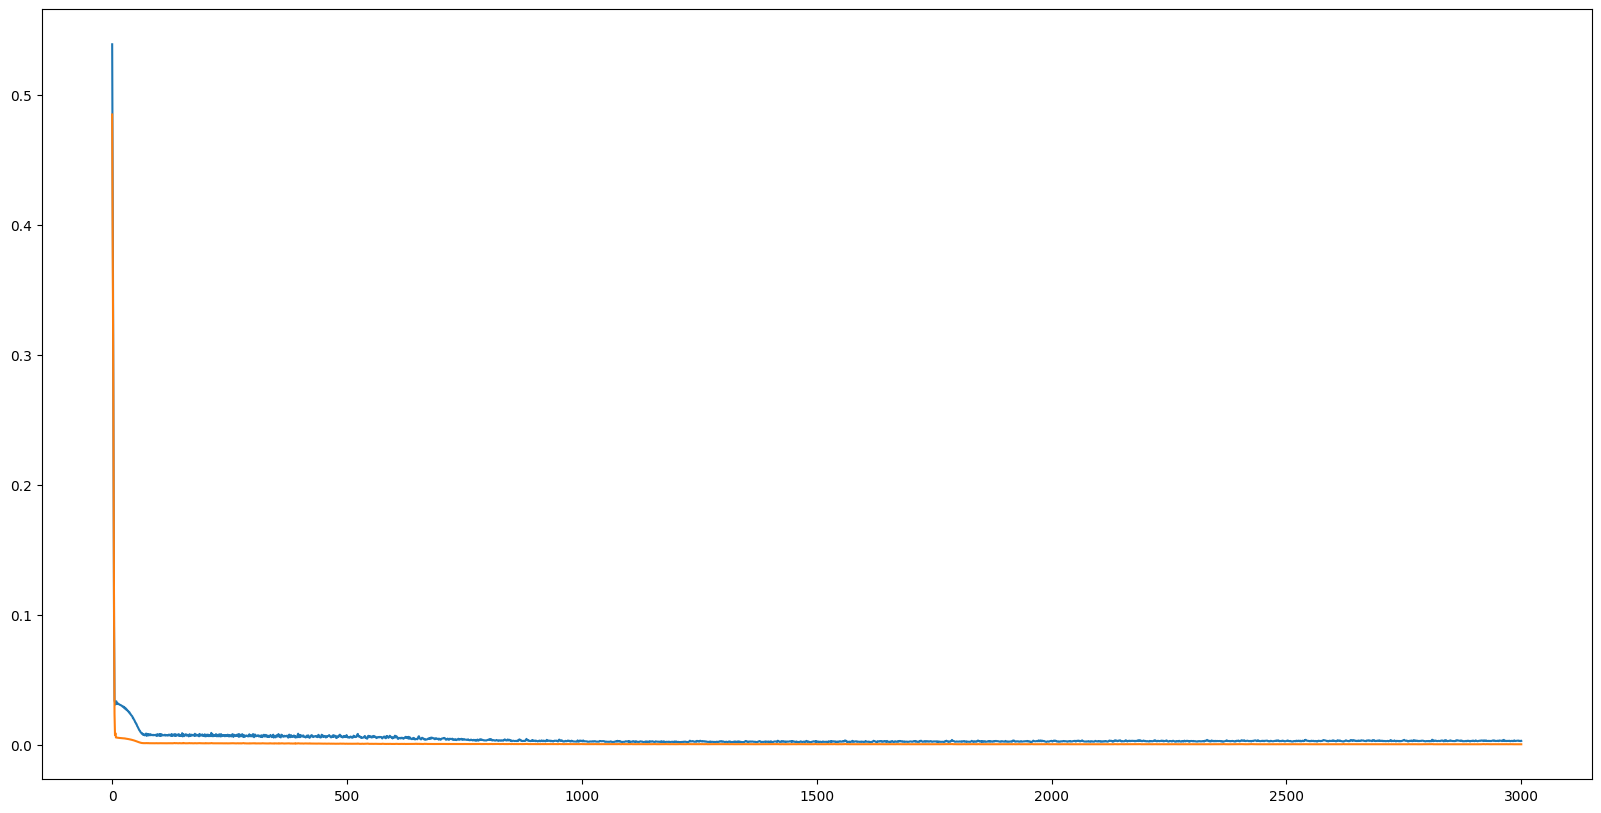

In [15]:
plt.figure(figsize=(20, 10))
plt.plot(val_loss_graph)
plt.plot(loss_graph)
plt.show()

# Prediction

In [17]:
concatdata = ConcatDataset([train, test])
data_loader = DataLoader(dataset=concatdata, batch_size=100)

with torch.no_grad():
    pred = list()
    lstm_model.eval()

    for data in data_loader:
        seq, target = data
        out = lstm_model(seq)
        pred += out.tolist()

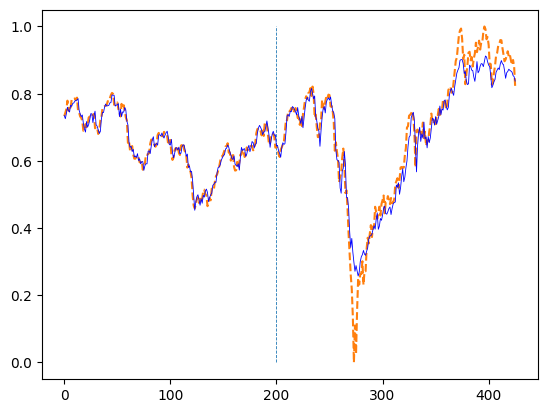

In [18]:
plt.plot(np.ones(100) * len(train), np.linspace(0, 1, 100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values, '--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.show()